In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
import optuna
import neptune.integrations.optuna as optuna_utils
import neptune.new as neptune
from optuna.integration import KerasPruningCallback
from tensorflow.keras import layers
from tensorflow.keras import models
import os
# Pre-Trained Models
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2, ResNet50V2, ResNet50

# Model
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Layer, ReLU, Add, InputLayer, Multiply

# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint


[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.


In [ ]:
path = 'Peaches'

In [ ]:
generator = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,

    height_shift_range=0.2,

    shear_range=0.2,

    zoom_range=0.2,

    horizontal_flip=True,

    fill_mode='nearest',
    validation_split=0.2)

In [ ]:
train_data = generator.flow_from_directory(
    path,
    target_size = (256, 256),
    batch_size = 64,
    class_mode = 'binary',
    seed = 123,
    shuffle = True,
    subset = 'training')

Found 475 images belonging to 2 classes.


In [ ]:
test_data = generator.flow_from_directory(
    path,
    target_size = (256, 256),
    batch_size = 64,
    class_mode = 'binary',
    seed = 123,
    shuffle = True,
    subset = 'validation')

Found 118 images belonging to 2 classes.


### Optuna

In [ ]:
def objective(trial):

    learning_rate = trial.suggest_float('learning_rate', 0.0005, 0.1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3)
    units_1 = trial.suggest_int('units_1', 64, 512)
    units_2 = trial.suggest_int('units_2', 32, 256)
    num_conv_layers = trial.suggest_int('num_conv_layers', 2, 5)
    filters_1 = trial.suggest_int('filters_1', 32, 128)
    filters_2 = trial.suggest_int('filters_2', 16, 64)


    model = models.Sequential()
    model.add(layers.Conv2D(filters_1, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    for _ in range(num_conv_layers - 1):
        model.add(layers.Conv2D(filters_2, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(units_1, activation='relu'))
    model.add(layers.Dense(units_2, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(2, activation='softmax'))


    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


    history = model.fit(
        train_data,
        epochs=10,
        callbacks=[KerasPruningCallback(trial, 'val_loss'), early_stopping]
    )



    true_labels = []
    predicted_labels = []
    num_batches = len(test_data)
    for i in range(num_batches):
        x_batch, y_batch = test_data[i]
        predictions = model.predict(x_batch)
        true_labels.extend(y_batch)
        predicted_labels.extend(np.argmax(predictions, axis=1))

    f1 = f1_score(true_labels, predicted_labels, average="weighted")

    # run['parameters/learning_rate'].log(learning_rate)
    # run['parameters/dropout_rate'].log(dropout_rate)
    # run['parameters/units_1'].log(units_1)
    # run['parameters/units_2'].log(units_2)
    # run['metrics/f1_score'].log(f1)


    return f1

study = optuna.create_study(direction='maximize')


study.optimize(objective, n_trials=10)

print(f"Best trial: {study.best_trial}")
print(f"  Value: {study.best_value}")
print(f"  Params: {study.best_params}")

# Get the best hyperparameters
best_learning_rate = study.best_params['learning_rate']
best_dropout_rate = study.best_params['dropout_rate']
best_units_1 = study.best_params['units_1']
best_units_2 = study.best_params['units_2']
best_num_conv_layers = study.best_params['num_conv_layers']
best_filters_1 = study.best_params['filters_1']
best_filters_2 = study.best_params['filters_2']

# Create the final model with best hyperparameters
best_model = models.Sequential()
best_model.add(layers.Conv2D(best_filters_1, (3, 3), activation='relu', input_shape=(256, 256, 3)))
best_model.add(layers.MaxPooling2D((2, 2)))

for _ in range(best_num_conv_layers - 1):
    best_model.add(layers.Conv2D(best_filters_2, (3, 3), activation='relu'))
    best_model.add(layers.MaxPooling2D((2, 2)))

best_model.add(layers.Flatten())
best_model.add(layers.Dense(best_units_1, activation='relu'))
best_model.add(layers.Dense(best_units_2, activation='relu'))
best_model.add(layers.Dropout(best_dropout_rate))
best_model.add(layers.Dense(2, activation='softmax'))

best_model.compile(
    optimizer=Adam(learning_rate=best_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

best_model.fit(
    train_data,
    epochs=10,
)

[I 2024-10-01 14:11:48,581] A new study created in memory with name: no-name-1d923fa5-7452-4203-8629-9aaf8863b82f


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.4623 - loss: 2962.2222
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.5400 - loss: 0.7708
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.4900 - loss: 0.7576
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5662 - loss: 0.6930
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.4988 - loss: 0.7616
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.5155 - loss: 0.6981
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.5957 - loss: 0.6804
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.5867 - loss: 0.6891
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.4992 - loss: 0.6947
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.5694 - loss: 0.6900
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step


[I 2024-10-01 14:20:09,928] Trial 0 finished with value: 0.42135957718243117 and parameters: {'learning_rate': 0.0483664906332232, 'dropout_rate': 0.00429454603150533, 'units_1': 354, 'units_2': 247, 'num_conv_layers': 4, 'filters_1': 95, 'filters_2': 20}. Best is trial 0 with value: 0.42135957718243117.
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.5076 - loss: 1.1085
Epoch 2/10


C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\optuna_integration\keras\keras.py:58: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.5418 - loss: 0.6852
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 73s 7s/step - accuracy: 0.6810 - loss: 0.6343
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 7s/step - accuracy: 0.5998 - loss: 0.6550
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.6827 - loss: 0.5969
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 745s 102s/step - accuracy: 0.7021 - loss: 0.5777
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - accuracy: 0.7307 - loss: 0.5224
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.7457 - loss: 0.5259
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.7752 - loss: 0.4925
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - accuracy: 0.7746 - loss: 0.4708
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 607ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


[I 2024-10-01 14:44:02,729] Trial 1 finished with value: 0.7180308667493454 and parameters: {'learning_rate': 0.0007936124483115393, 'dropout_rate': 0.29104955493278156, 'units_1': 406, 'units_2': 148, 'num_conv_layers': 3, 'filters_1': 94, 'filters_2': 50}. Best is trial 1 with value: 0.7180308667493454.
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.5609 - loss: 113.8594
Epoch 2/10


C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\optuna_integration\keras\keras.py:58: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.6035 - loss: 0.6788
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.5794 - loss: 0.6891
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.6020 - loss: 0.6842
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.5697 - loss: 0.6836
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.6035 - loss: 0.6820
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.5746 - loss: 0.6821
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.5649 - loss: 0.6849
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.6004 - loss: 0.6759
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.5800 - loss: 0.6829
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000244218D3EC0> triggered tf.function retracing. Tr

[I 2024-10-01 14:52:47,776] Trial 2 finished with value: 0.42135957718243117 and parameters: {'learning_rate': 0.020092113022162666, 'dropout_rate': 0.2775608721981481, 'units_1': 194, 'units_2': 125, 'num_conv_layers': 4, 'filters_1': 107, 'filters_2': 20}. Best is trial 1 with value: 0.7180308667493454.
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.5112 - loss: 23.5487
Epoch 2/10


C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\optuna_integration\keras\keras.py:58: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5025 - loss: 0.9563
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5702 - loss: 0.6882
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.5683 - loss: 0.6873
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.5698 - loss: 0.6852
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.5750 - loss: 0.7400
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.5820 - loss: 0.6821
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.6182 - loss: 0.6727
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.5528 - loss: 0.6870
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5811 - loss: 0.6798
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2024-10-01 14:59:23,545] Trial 3 finished with value: 0.42135957718243117 and parameters: {'learning_rate': 0.0030755131606851433, 'dropout_rate': 0.19319886586279825, 'units_1': 119, 'units_2': 35, 'num_conv_layers': 2, 'filters_1': 59, 'filters_2': 62}. Best is trial 1 with value: 0.7180308667493454.
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.5311 - loss: 24.9349
Epoch 2/10


C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\optuna_integration\keras\keras.py:58: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.5484 - loss: 0.6918
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.5994 - loss: 0.6982
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.5690 - loss: 0.6843
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.6075 - loss: 0.6808
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.6119 - loss: 0.6759
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.6438 - loss: 0.6618
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7128 - loss: 0.6245
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.6823 - loss: 0.6307
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.7356 - loss: 0.5692
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step


[I 2024-10-01 15:04:26,642] Trial 4 finished with value: 0.710462779239389 and parameters: {'learning_rate': 0.0029405062185513028, 'dropout_rate': 0.006209670625869479, 'units_1': 234, 'units_2': 97, 'num_conv_layers': 2, 'filters_1': 39, 'filters_2': 59}. Best is trial 1 with value: 0.7180308667493454.
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - accuracy: 0.4692 - loss: 3.8218
Epoch 2/10


C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\optuna_integration\keras\keras.py:58: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - accuracy: 0.5001 - loss: 0.7708
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - accuracy: 0.5668 - loss: 0.6845
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.5932 - loss: 0.6777
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.5726 - loss: 0.6842
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.5859 - loss: 0.6799
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.5667 - loss: 0.6840
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.5700 - loss: 0.6853
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.5378 - loss: 0.6928
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.5912 - loss: 0.6786
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


[I 2024-10-01 15:13:59,019] Trial 5 finished with value: 0.42135957718243117 and parameters: {'learning_rate': 0.012169848550988727, 'dropout_rate': 0.21138256438214154, 'units_1': 125, 'units_2': 118, 'num_conv_layers': 4, 'filters_1': 106, 'filters_2': 41}. Best is trial 1 with value: 0.7180308667493454.
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.5084 - loss: 160.9863
Epoch 2/10


C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\optuna_integration\keras\keras.py:58: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.5097 - loss: 1.7875
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5437 - loss: 0.6944
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5996 - loss: 0.6746
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.5827 - loss: 1.3644
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5882 - loss: 0.6849
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5738 - loss: 0.6854
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5851 - loss: 0.6819
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5583 - loss: 0.6877
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5942 - loss: 0.6761
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step


[I 2024-10-01 15:21:10,101] Trial 6 finished with value: 0.42135957718243117 and parameters: {'learning_rate': 0.01330788327796584, 'dropout_rate': 0.2742504825761669, 'units_1': 361, 'units_2': 180, 'num_conv_layers': 3, 'filters_1': 66, 'filters_2': 57}. Best is trial 1 with value: 0.7180308667493454.
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.5294 - loss: 9.8614
Epoch 2/10


C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\optuna_integration\keras\keras.py:58: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.6314 - loss: 0.6455
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7046 - loss: 0.5656
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7181 - loss: 0.5641
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7730 - loss: 0.5148
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7872 - loss: 0.4449
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7708 - loss: 0.4642
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7865 - loss: 0.4526
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.8526 - loss: 0.3377
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8605 - loss: 0.3821
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step


[I 2024-10-01 15:26:25,784] Trial 7 finished with value: 0.8622779005977237 and parameters: {'learning_rate': 0.0014484322019529742, 'dropout_rate': 0.10108954883098667, 'units_1': 187, 'units_2': 221, 'num_conv_layers': 2, 'filters_1': 44, 'filters_2': 62}. Best is trial 7 with value: 0.8622779005977237.
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.5224 - loss: 1.1445
Epoch 2/10


C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\optuna_integration\keras\keras.py:58: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.6018 - loss: 0.6782
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5661 - loss: 0.6690
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.6273 - loss: 0.6400
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.7264 - loss: 0.5809
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7461 - loss: 0.5329
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.7416 - loss: 0.5240
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.7251 - loss: 0.5791
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.7465 - loss: 0.5412
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7838 - loss: 0.4933
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step


[I 2024-10-01 15:33:04,764] Trial 8 finished with value: 0.7249790120935722 and parameters: {'learning_rate': 0.0021360644868193245, 'dropout_rate': 0.12982524263895134, 'units_1': 387, 'units_2': 185, 'num_conv_layers': 4, 'filters_1': 70, 'filters_2': 45}. Best is trial 7 with value: 0.8622779005977237.
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.5292 - loss: 22623.3711
Epoch 2/10


C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\optuna_integration\keras\keras.py:58: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.5687 - loss: 0.7534
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 77s 9s/step - accuracy: 0.5569 - loss: 0.6926
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - accuracy: 0.5961 - loss: 0.6828
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 73s 8s/step - accuracy: 0.5706 - loss: 0.6852
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 69s 8s/step - accuracy: 0.5515 - loss: 0.6882
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 75s 8s/step - accuracy: 0.5829 - loss: 0.6823
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 70s 8s/step - accuracy: 0.5699 - loss: 0.6862
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - accuracy: 0.5746 - loss: 0.6843
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 7s/step - accuracy: 0.5512 - loss: 0.6889
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


[I 2024-10-01 15:44:50,920] Trial 9 finished with value: 0.42135957718243117 and parameters: {'learning_rate': 0.0659478442080108, 'dropout_rate': 0.24682149253012312, 'units_1': 253, 'units_2': 152, 'num_conv_layers': 4, 'filters_1': 128, 'filters_2': 39}. Best is trial 7 with value: 0.8622779005977237.


Best trial: FrozenTrial(number=7, state=1, values=[0.8622779005977237], datetime_start=datetime.datetime(2024, 10, 1, 15, 21, 10, 110336), datetime_complete=datetime.datetime(2024, 10, 1, 15, 26, 25, 781294), params={'learning_rate': 0.0014484322019529742, 'dropout_rate': 0.10108954883098667, 'units_1': 187, 'units_2': 221, 'num_conv_layers': 2, 'filters_1': 44, 'filters_2': 62}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=0.0005, step=None), 'dropout_rate': FloatDistribution(high=0.3, log=False, low=0.0, step=None), 'units_1': IntDistribution(high=512, log=False, low=64, step=1), 'units_2': IntDistribution(high=256, log=False, low=32, step=1), 'num_conv_layers': IntDistribution(high=5, log=False, low=2, step=1), 'filters_1': IntDistribution(high=128, log=False, low=32, step=1), 'filters_2': IntDistribution(high=64, log=False, low=16, step=1)}, trial_id=7, value=None)
  Value: 0.8622779005977237
  Par

C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 329s 45s/step - accuracy: 0.5834 - loss: 23.7748
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5026 - loss: 0.9057
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5771 - loss: 0.6721
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5925 - loss: 0.6754
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5994 - loss: 0.6613
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7264 - loss: 0.6051
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7333 - loss: 0.5335
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7318 - loss: 0.5747
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7275 - loss: 0.5655
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.7633 - loss: 0.5410


In [ ]:
best_learning_rate = study.best_params['learning_rate']
best_dropout_rate = study.best_params['dropout_rate']
best_units_1 = study.best_params['units_1']
best_units_2 = study.best_params['units_2']
best_num_conv_layers = study.best_params['num_conv_layers']
best_filters_1 = study.best_params['filters_1']
best_filters_2 = study.best_params['filters_2']

In [ ]:
best_learning_rate = 0.0014484322019529742
best_dropout_rate = 0.10108954883098667
best_units_1 = 187
best_units_2 = 221
best_num_conv_layers = 2
best_filters_1 = 44
best_filters_2 = 62

In [ ]:
true_labels1 = []
predict_labels1 = []

for i in range(len(test_data)):
        x, y = test_data[i]
        true_labels1.extend(y)
        predictions1 = best_model.predict(x)
        predict_labels1.extend(np.argmax(predictions1, axis = 1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step


### best model's reuslt from optuna

In [ ]:
f1_1 = f1_score(true_labels1, predict_labels1, average = 'weighted')
acc_1 = accuracy_score(true_labels1, predict_labels1)
print(f1_1, acc_1)

0.84825465548203 0.847457627118644


### model wihout using optuna

In [ ]:
model = Sequential(
        [Conv2D(32, (3,3), activation = 'relu', input_shape = (256,256,3)), #check why do we need an activaion fucntion here
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation = 'relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(64, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(2, activation = 'softmax')]
)


C:\Users\Алёна\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(train_data, epochs = 1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.4650 - loss: 3.5820


In [ ]:
true_labels = []
predict_labels = []

for i in range(len(test_data)):
        x, y = test_data[i]
        true_labels.extend(y)
        predictions = model.predict(x)
        predict_labels.extend(np.argmax(predictions, axis = 1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step


In [ ]:
f1 = f1_score(true_labels, predict_labels, average = 'weighted')
acc = accuracy_score(true_labels, predict_labels)

In [ ]:
f1

0.81453346781137

In [ ]:
acc

0.8135593220338984

In [ ]:
from keras.models import Model

In [ ]:
len(train_data)

8

In [ ]:
print(model.layers[0].input)

<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=False, name=keras_tensor>


In [ ]:
for layer in model.layers:
    print(layer.input)

<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=False, name=keras_tensor_75>
<KerasTensor shape=(None, 254, 254, 32), dtype=float32, sparse=False, name=keras_tensor_76>
<KerasTensor shape=(None, 127, 127, 32), dtype=float32, sparse=False, name=keras_tensor_77>
<KerasTensor shape=(None, 125, 125, 64), dtype=float32, sparse=False, name=keras_tensor_78>
<KerasTensor shape=(None, 62, 62, 64), dtype=float32, sparse=False, name=keras_tensor_79>
<KerasTensor shape=(None, 246016), dtype=float32, sparse=False, name=keras_tensor_80>
<KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_81>
<KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_82>


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


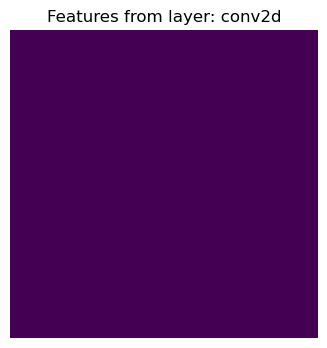

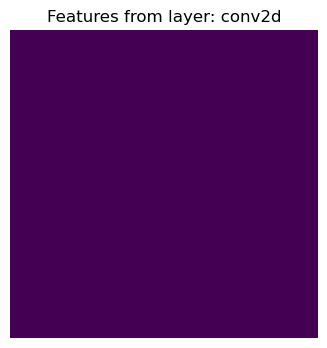

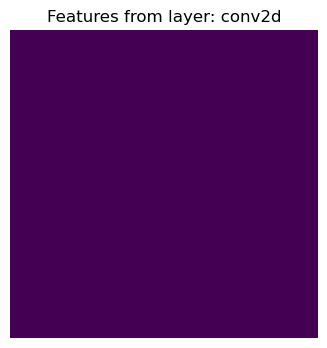

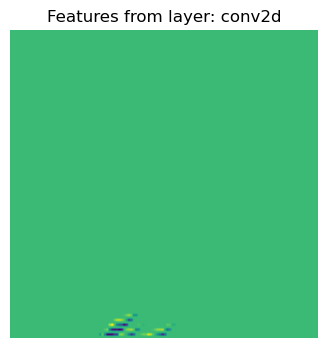

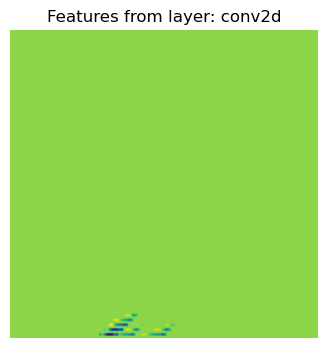

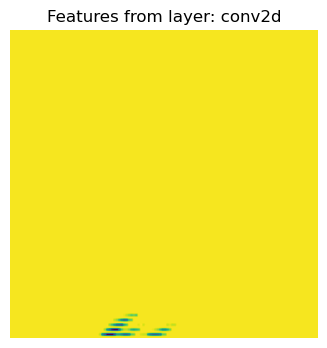

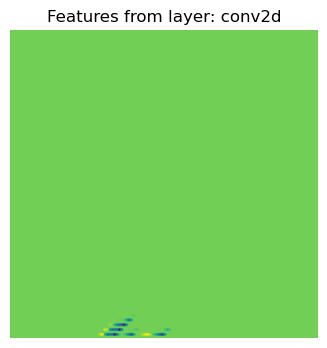

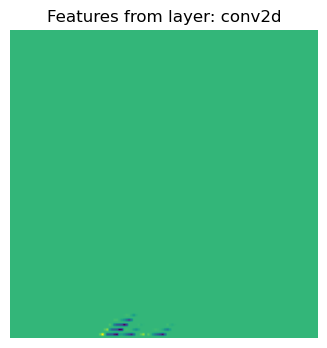

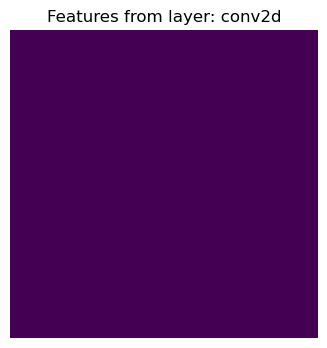

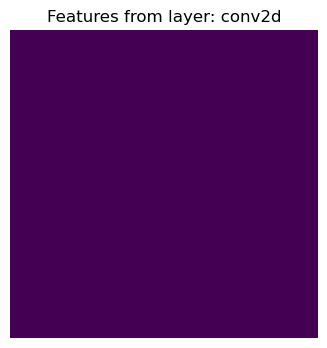

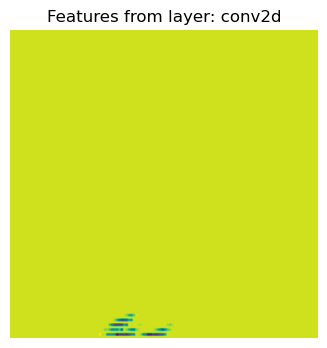

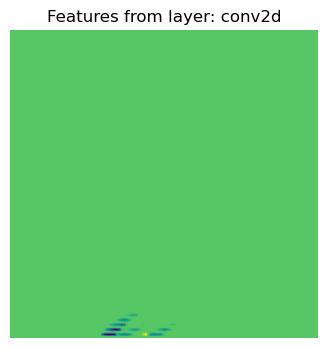

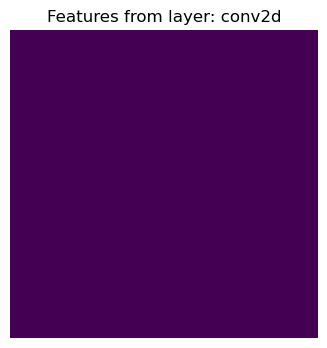

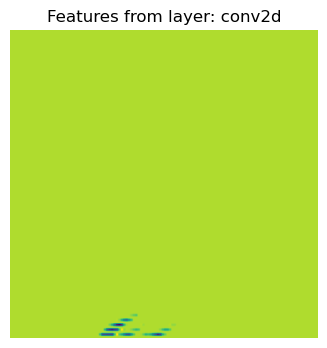

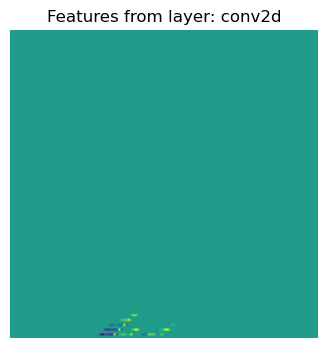

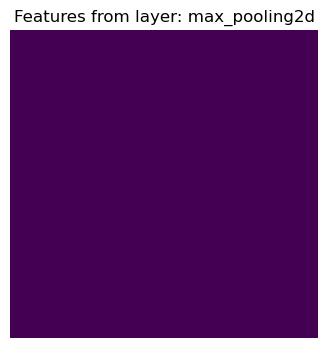

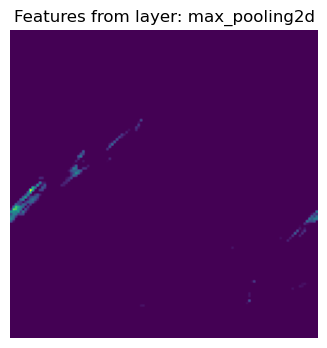

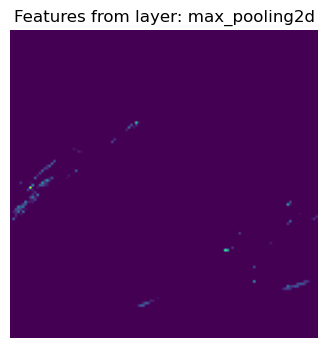

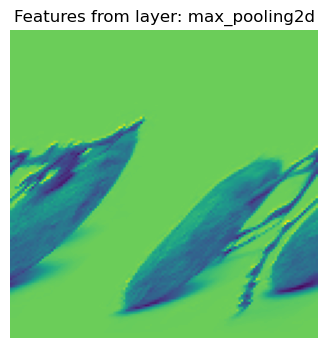

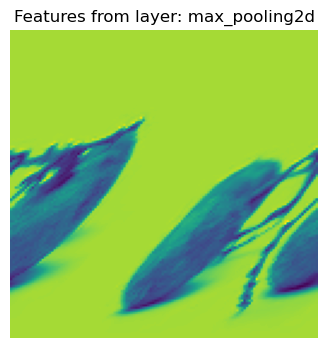

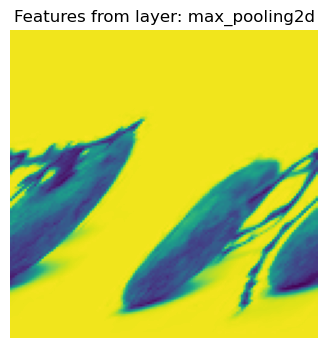

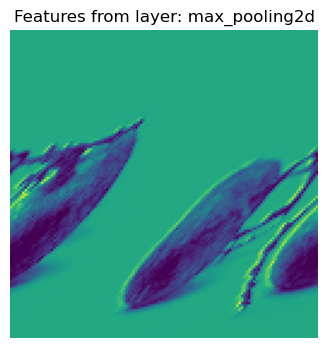

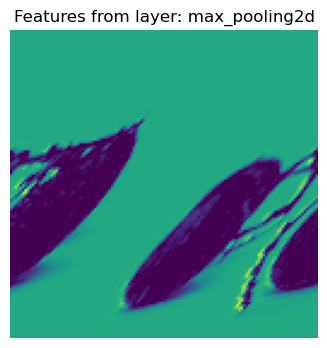

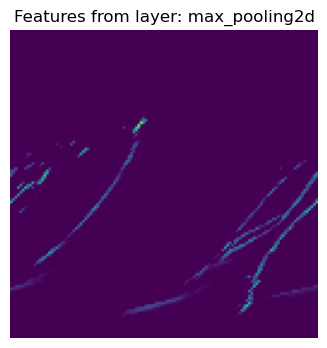

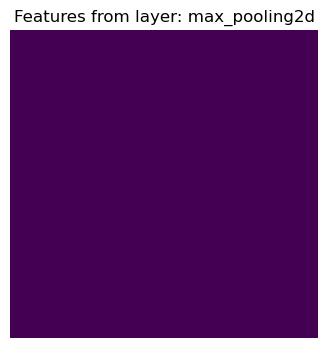

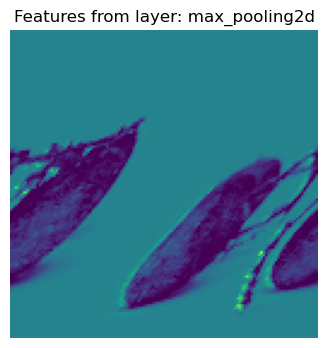

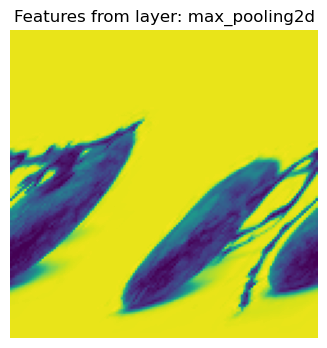

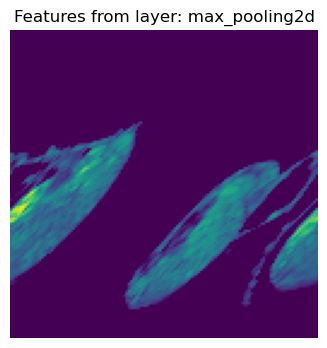

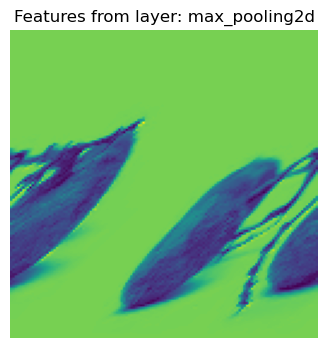

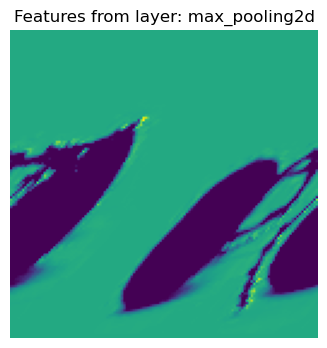

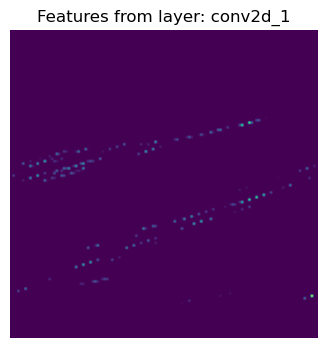

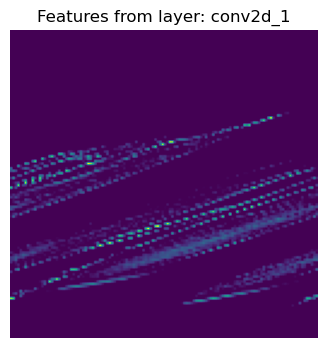

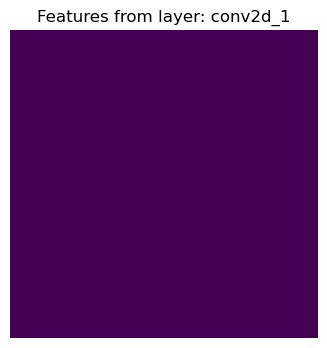

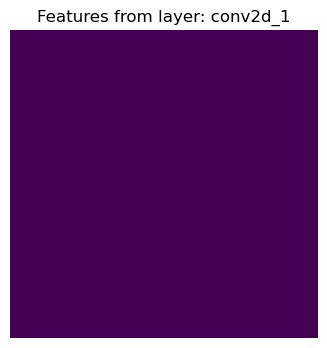

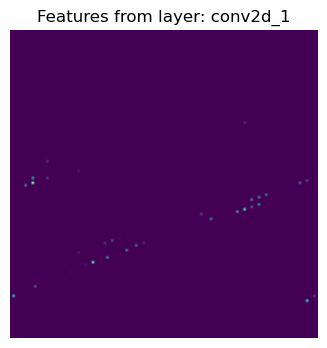

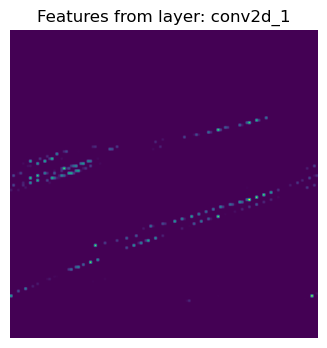

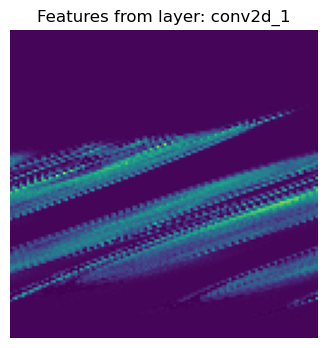

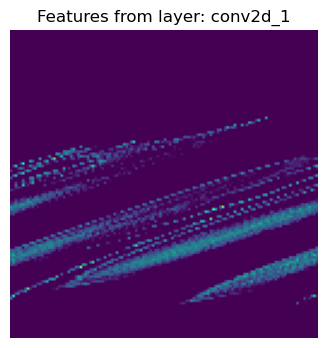

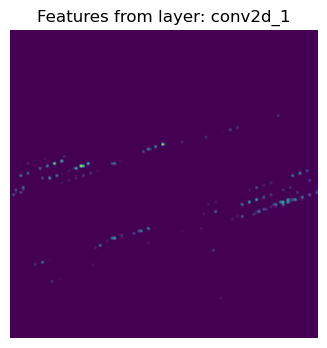

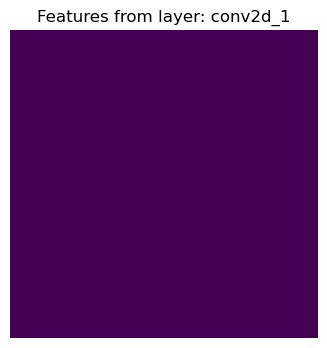

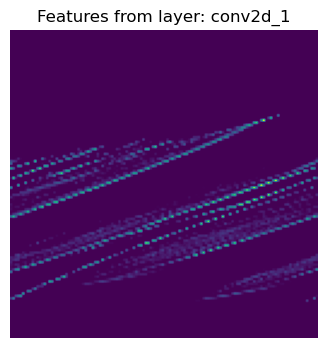

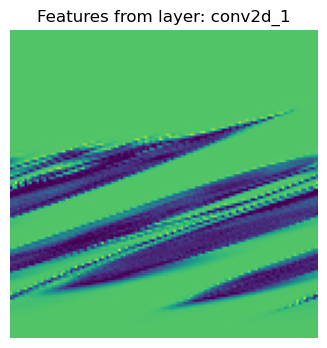

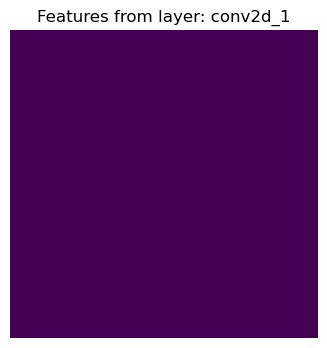

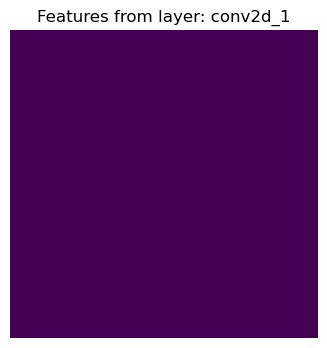

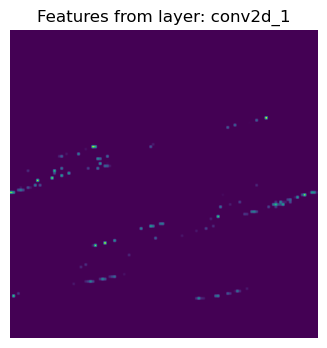

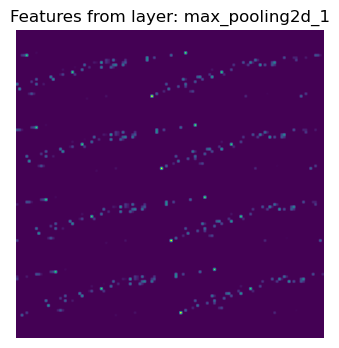

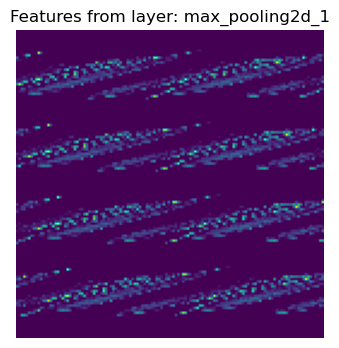

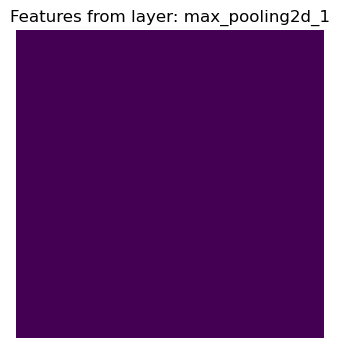

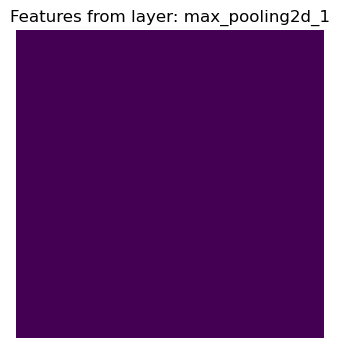

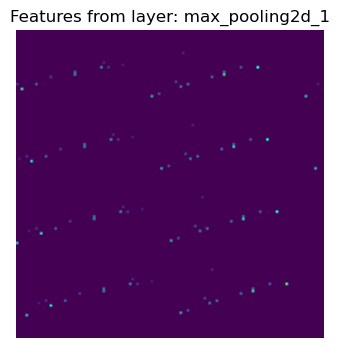

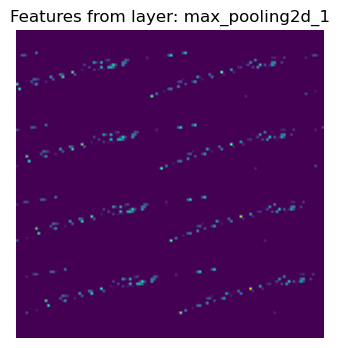

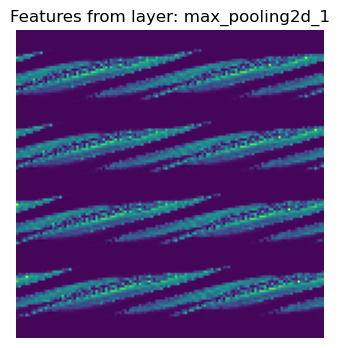

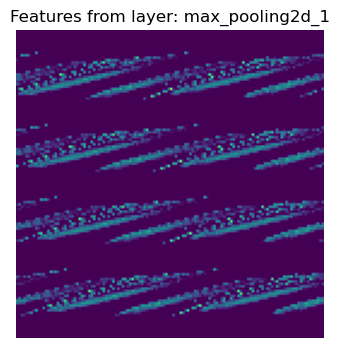

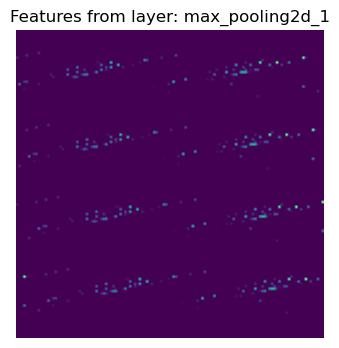

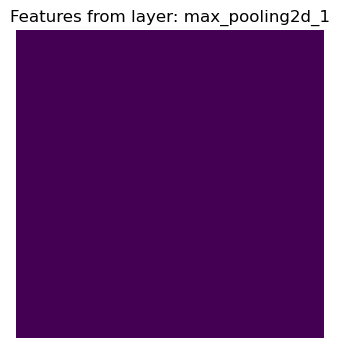

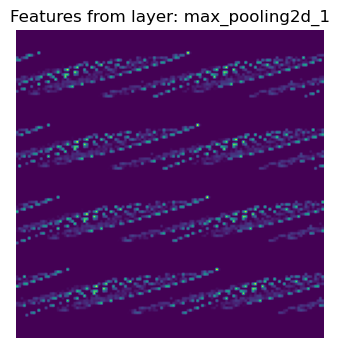

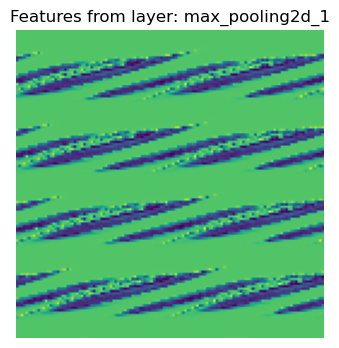

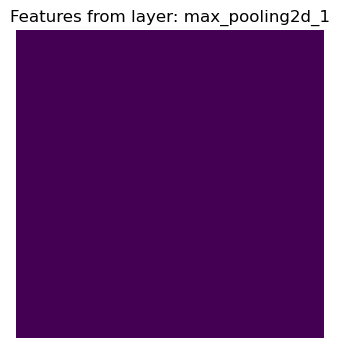

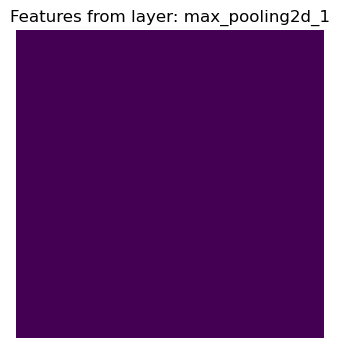

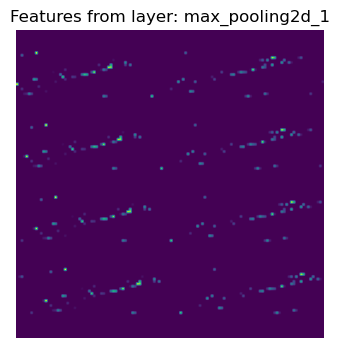

In [ ]:
img = train_data[0][0][0]
img = np.expand_dims(img, axis=0)  # расширим измерения для соответствия входному формату модели

# Получим выходные данные каждого слоя для выбранного изображения
layer_outputs = [layer.output for layer in model.layers]
layer_inputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.layers[0].input, outputs=layer_outputs)
activations = activation_model.predict(img)

# Функция для интерполяции изображений до размера 128x128
def upscale_to_128x128(img):
    return np.resize(img, (128, 128))

# Визуализация признаков
for layer_name, layer_activation in zip([layer.name for layer in model.layers], activations):
    # Если активация имеет 4 измерения (как в случае с Conv2D и MaxPooling2D)
    if len(layer_activation.shape) == 4:
        # Выберем первые 6 признаковых карт для визуализации
        for i in range(15):
            plt.figure(figsize=(16, 4))

            # Некоторые слои могут иметь менее 6 каналов, в таком случае мы визуализируем только имеющиеся
            if layer_activation.shape[-1] >= i+1:
                channel_image = layer_activation[0, :, :, i]
                channel_image = upscale_to_128x128(channel_image)  # Интерполяция до размера 128x128
                plt.imshow(channel_image, cmap='viridis')
                plt.title(f"Features from layer: {layer_name}")
                plt.axis('off')
        plt.show()

### Resnet

In [ ]:
root_path = 'Peaches'

class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

In [ ]:
name = 'resnet'

base_model = ResNet152V2(include_top=False, input_shape=(256,256,3))
base_model.trainable = False

# Model
model3 = Sequential([
    base_model,
    Flatten(),
    # Dense(256, activation='relu'),
    # Dropout(0.4),
    # Dense(128, activation='relu'),
    # Dropout(0.2),
    Dense(n_classes, activation="softmax")
])


model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(name + ".keras", save_best_only=True)
]

In [ ]:
model3.fit(train_data, epochs=5, callbacks=cbs)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 186s 14s/step - accuracy: 0.7122 - loss: 1.8880
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 129s 14s/step - accuracy: 0.9090 - loss: 1.2422
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 138s 15s/step - accuracy: 0.9176 - loss: 1.0172
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 129s 14s/step - accuracy: 0.9511 - loss: 0.7117
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 129s 14s/step - accuracy: 0.9328 - loss: 0.7268


In [ ]:
true_labels = []
predicted_labels = []
class_names = list(class_names)
num_batches = len(test_data)
for i in range(num_batches):
    x_batch, y_batch = test_data[i]
    predictions = model3.predict(x_batch)
    true_labels.extend(y_batch)
    predicted_labels.extend(np.argmax(predictions, axis=1))

f1 = f1_score(true_labels, predicted_labels, average="weighted")


2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 20s/step


In [ ]:
f1

0.9577663098011608